# I. Data Preparation (equal bin)

The goal of this dataset is to clean the data set we'll use for data visualizations and training the model.

We'll proceed to:
- Data Exploration and data split
- Feature Engineering (categorical encoding using equal bin discretiser and top/bottom encoding)
- Save data for feature predictions


## Part I : Data Exploratoin

####  1. Importing libraries and data

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# for tree binarisation
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score


# to build the models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb

# to evaluate the models
from sklearn.metrics import mean_squared_error
from math import sqrt

pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


#Scaling
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



#### 2. Import and merge datasets

In [2]:
df=pd.read_csv('Credit-Scoring-Clean.csv')
df.shape

(950, 21)

In [3]:
#column list
df.columns

Index(['CheckingAcctStat', 'Duration', 'CreditHistory', 'Purpose',
       'CreditAmount', 'Savings', 'Employment', 'InstallmentRatePecnt',
       'SexAndStatus', 'OtherDetorsGuarantors', 'PresentResidenceTime',
       'Property', 'Age', 'OtherInstalments', 'Housing',
       'ExistingCreditsAtBank', 'Job', 'NumberDependents', 'Telephone',
       'ForeignWorker', 'CreditStatus'],
      dtype='object')

#### 3. Drop duplicate rows and columns

In [4]:
#drop duplicate rows (using subset, I drop raws where values of columns mentioned match)
df.drop_duplicates(subset=['CheckingAcctStat', 'Duration', 'CreditHistory', 'Purpose',
       'CreditAmount', 'Savings', 'Employment', 'InstallmentRatePecnt',
       'SexAndStatus', 'OtherDetorsGuarantors', 'PresentResidenceTime',
       'Property', 'Age', 'OtherInstalments', 'Housing',
       'ExistingCreditsAtBank', 'Job', 'NumberDependents', 'Telephone',
       'ForeignWorker', 'CreditStatus'], inplace = True)

In [5]:
#see shape after duplicate row removal
df.shape

(950, 21)

There were no duplicate rows

In [6]:
# remove duplicate columns
_, i = np.unique(df.columns, return_index=True)
df=df.iloc[:, i]
df.shape

(950, 21)

In [7]:
df.head()

,Age,CheckingAcctStat,CreditAmount,CreditHistory,CreditStatus,Duration,Employment,ExistingCreditsAtBank,ForeignWorker,Housing,InstallmentRatePecnt,Job,NumberDependents,OtherDetorsGuarantors,OtherInstalments,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone
0,0.089286,A11,0.161770,A32,1,0.205882,A73,0.0,A201,A152,0.333333,A173,0.0,A101,A143,0.333333,A121,A43,A61,A92,A191
1,0.125000,A14,0.058380,A32,0,0.294118,A74,0.0,A201,A152,1.000000,A173,0.0,A101,A143,0.666667,A122,A43,A62,A94,A192
2,0.232143,A14,0.069055,A32,0,0.205882,A73,0.0,A201,A153,1.000000,A174,0.0,A101,A143,0.333333,A124,A43,A61,A93,A192
3,0.214286,A11,0.358094,A32,1,0.647059,A73,0.0,A201,A152,0.666667,A173,0.0,A101,A143,0.333333,A123,A43,A61,A92,A192
4,0.178571,A13,0.023825,A33,0,0.029412,A72,0.0,A201,A152,0.333333,A173,0.0,A101,A141,0.000000,A122,A43,A61,A92,A191


There were no duplicate columns

#### 4. Types of Variables

In [8]:
# let's inspect the type of variables in pandas
df.dtypes

Age                      float64
CheckingAcctStat          object
CreditAmount             float64
CreditHistory             object
CreditStatus               int64
Duration                 float64
Employment                object
ExistingCreditsAtBank    float64
ForeignWorker             object
Housing                   object
InstallmentRatePecnt     float64
Job                       object
NumberDependents         float64
OtherDetorsGuarantors     object
OtherInstalments          object
PresentResidenceTime     float64
Property                  object
Purpose                   object
Savings                   object
SexAndStatus              object
Telephone                 object
dtype: object

There are a mixture of numerical and categorical variables. Normally object type determines categorical. 

#### 4.1 Find categorical variables

In [9]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))
categorical

There are 13 categorical variables


['CheckingAcctStat',
 'CreditHistory',
 'Employment',
 'ForeignWorker',
 'Housing',
 'Job',
 'OtherDetorsGuarantors',
 'OtherInstalments',
 'Property',
 'Purpose',
 'Savings',
 'SexAndStatus',
 'Telephone']

#### 4.2 Find temporal variables

In [10]:
# make a list of the numerical variables first
numerical = [var for var in df.columns if df[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var or 'Day'in var or 'Month'in var or 'Time'in var]
print('There are {} temporal variables'.format(len(year_vars)))


year_vars

There are 1 temporal variables


['PresentResidenceTime']

No temporal variables

#### 4.3 Find Discrete Varibles

In [11]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(df[var].unique())<20 and var not in year_vars:
        print(var, ' values: ', df[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))
discrete

CreditStatus  values:  [1 0]
ExistingCreditsAtBank  values:  [0.         0.33333333 1.         0.66666667 0.24793091 0.08540242
 0.05554672 0.27778661 0.41873575 0.11109345 0.17080484 0.38888006
 0.25620727 0.44442678 0.58126424]
NumberDependents  values:  [0.         1.         0.93402351 0.14386259 0.06597649 0.85613741]

There are 3 discrete variables


['CreditStatus', 'ExistingCreditsAtBank', 'NumberDependents']

In [12]:
### Find Continuous
# let's remember to skip the Id variable and the target variable SalePrice, which are both also numerical

numerical = [var for var in numerical if var not in discrete and var not in ['Id', 'SalePrice'] and var not in year_vars]
print('There are {} numerical and continuous variables'.format(len(numerical)))
numerical

There are 4 numerical and continuous variables


['Age', 'CreditAmount', 'Duration', 'InstallmentRatePecnt']

SO there are: 

- 3 discrete variables 
- 13 categorical 
- 1 temporal
- 4 continuous


#### 5.Types of problems within variables

#### 5.1 Missing values

I have very few missing values in general, except for the 'normalized-losses'and 'make'columns

In [13]:
# let's no determine how many variables we have with missing information

vars_with_na = [var for var in df.columns if df[var].isnull().sum()>0]
print('Total variables that contain missing information: ', len(vars_with_na))

Total variables that contain missing information:  0


There are a no variables with missing information!

In [14]:
# let's inspect the type of those variables with a lot of missing information
for var in df.columns:
    if df[var].isnull().mean()>0.80:
        print(var, df[var].unique())

In [15]:
# let's visualise the percentage of missing values for each variable
for var in df.columns:
    if df[var].isnull().sum()>0:
        print(var, df[var].isnull().mean())

No variables with any above 80% of values missing information

#### 5.2 Outliers

#### 5.2.1 Start with numerical 

In [16]:
# let's look at the continuous variables
numerical

['Age', 'CreditAmount', 'Duration', 'InstallmentRatePecnt']

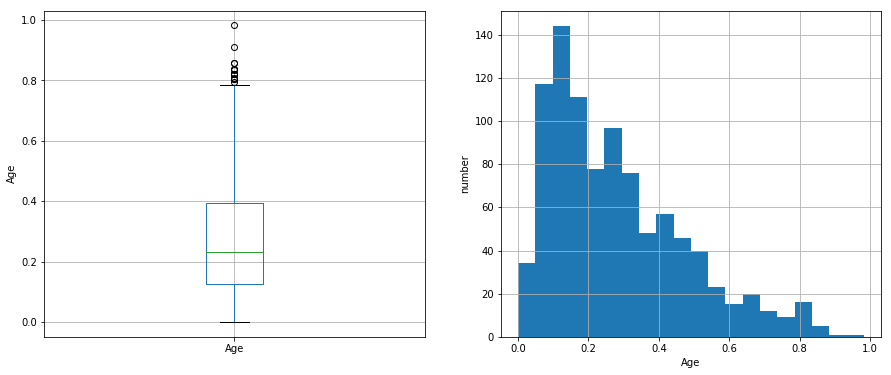

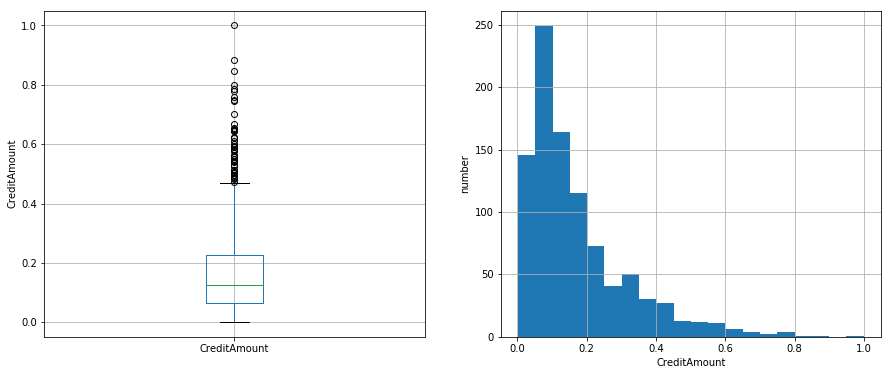

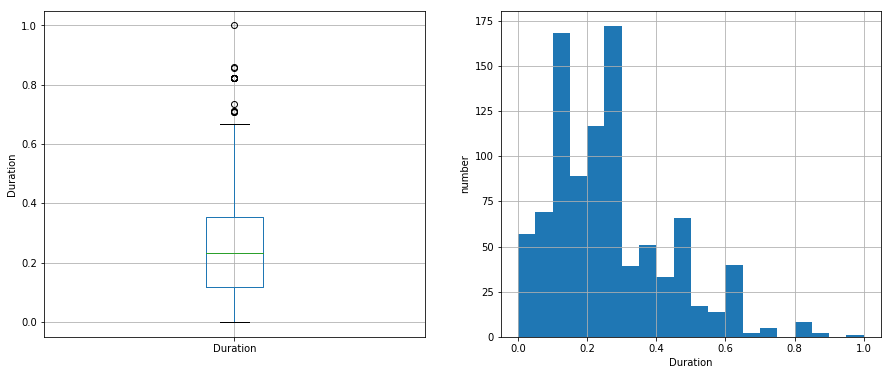

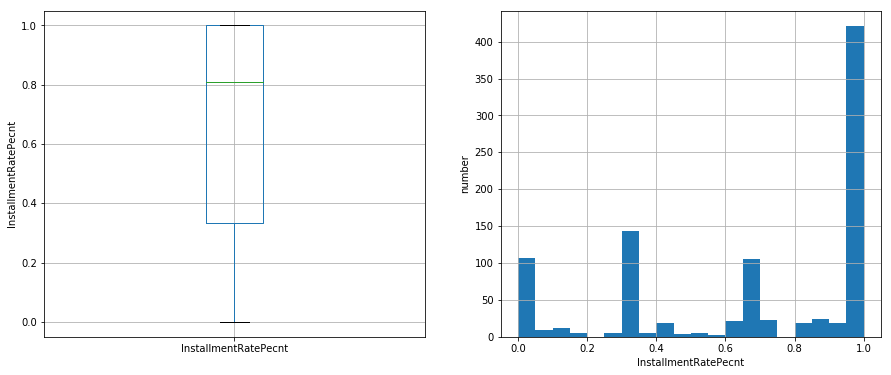

In [17]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('number')
    fig.set_xlabel(var)

    plt.show()

We can see the following variables present outliers:

- Duration (top)
- CreditAmount (top)
- Age (top)

#### 5.2.2 Continue with discrete variables

We'll consider outliers those labels in discrete variables that are pressent in less than 1% of observations

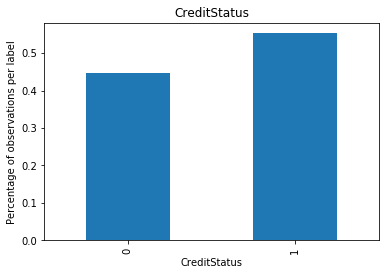

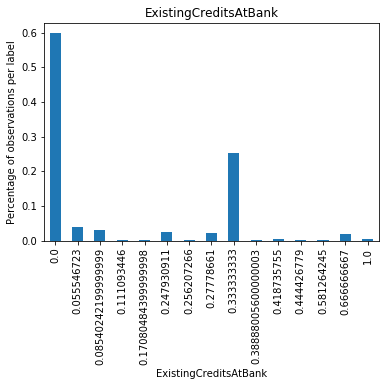

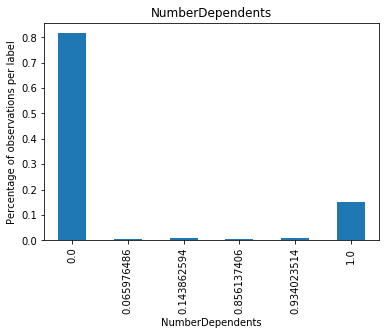

In [18]:
# outlies in discrete variables
for var in discrete:
    (df.groupby(var)[var].count() / np.float(len(df))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()
    #print(data[var].value_counts() / np.float(len(data)))
    print()

All dicrete variables, except for CreditStatus (which is the TARGET) present outliers

#### 5.2.3 Number of labels: Cardinality

Text(0, 0.5, 'Number of different categories')

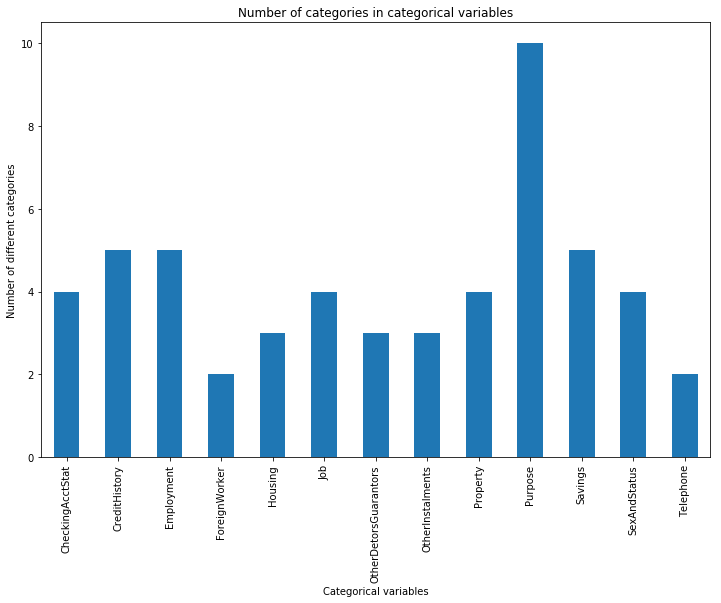

In [19]:
no_labels_ls = []
for var in categorical:
    no_labels_ls.append(len(df[var].unique()))
    
 
tmp = pd.Series(no_labels_ls)
tmp.index = pd.Series(categorical)
tmp.plot.bar(figsize=(12,8))
plt.title('Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Most of them have a few categories, except for **purpose** that has 10. Yet ten categories is a reasonable number. 

####  6. Split into train and test sets

In [20]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(df, df.CreditStatus, test_size=0.15,
                                                    random_state=0)
X_train.shape, X_test.shape

((807, 21), (143, 21))

In [21]:
X_train.columns

Index(['Age', 'CheckingAcctStat', 'CreditAmount', 'CreditHistory',
       'CreditStatus', 'Duration', 'Employment', 'ExistingCreditsAtBank',
       'ForeignWorker', 'Housing', 'InstallmentRatePecnt', 'Job',
       'NumberDependents', 'OtherDetorsGuarantors', 'OtherInstalments',
       'PresentResidenceTime', 'Property', 'Purpose', 'Savings',
       'SexAndStatus', 'Telephone'],
      dtype='object')

In [22]:
y_train.head()

424    0
841    1
346    0
418    0
682    1
Name: CreditStatus, dtype: int64

For some reason, CreditStatus shows up in X_train. Fine, but before I chose the columsn to go on Dataframe, I will to remove from X_train/X_test 

## Part II: Feature engineering

### 7. Engineering missing values

**7.1 Continuous variables**

In [23]:
# print variables with missing data
# keep in mind that now that we created those new temporal variables, we
# are going to treat them as numerical and continuous as well:


# examine percentage of missing values
for col in numerical+year_vars:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

No missing values in continuous variables

**7.2 Discrete variables**

I first redifine discrete variables (removing the TARGET)

In [24]:
discrete = ['ExistingCreditsAtBank', 'NumberDependents']

In [25]:
# print variables with missing data
for col in discrete:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())


There are no discrete variables variables with missing data



#### 7.3 Engineering Missing data in Categorical Variables

In [26]:
# print variables with missing data
for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, X_train[col].isnull().mean())

No missing values in Categorical variables

**Sanity check** to make sure I have no more nulls

In [27]:
# check absence of null values
for var in X_train.columns:
    if X_train[var].isnull().sum()>0:
        print(var, X_train[var].isnull().sum())

In [28]:
# check absence of null values
for var in X_test.columns:
    if X_test[var].isnull().sum()>0:
        print(var, X_test[var].isnull().sum())

Well done! I have no more NA in the variables.

### 8. Outlier engineering

#### 8.1 Outlier identification and strategy setting


In [29]:
numerical

['Age', 'CreditAmount', 'Duration', 'InstallmentRatePecnt']

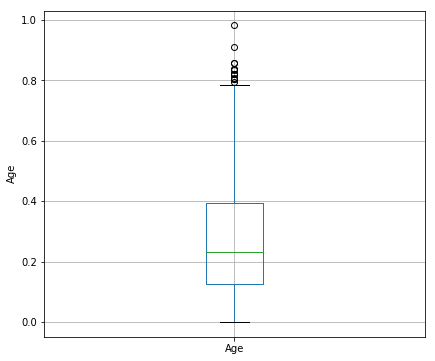

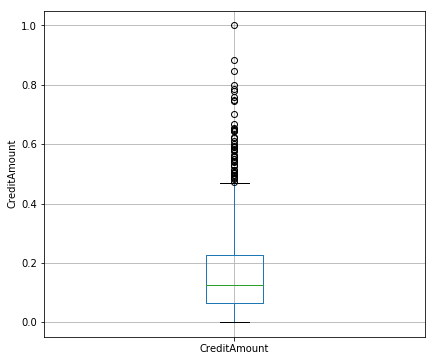

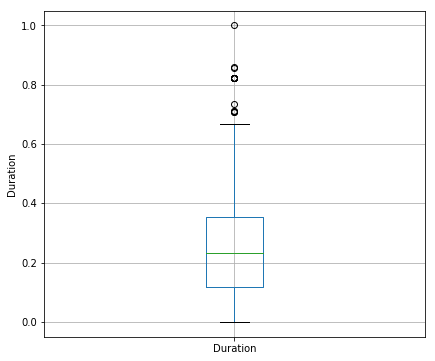

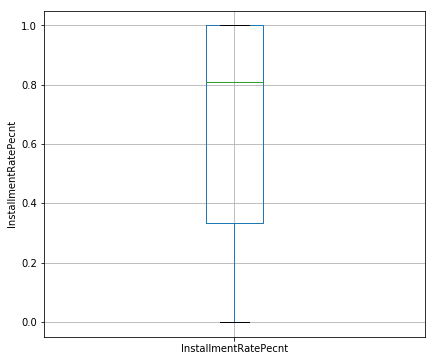

In [30]:
for var in numerical:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)

As we saw, the following variables present outliers:

- Duration (top)
- CreditAmount (top)
- Age (top)

To decide how to handle these outliers, I shall check for their distribution skewness.
   

In [31]:
# let's find the skewness of above variables
for var in ['Duration','CreditAmount','Age']:
    print(var, 'skewness is', df[var].skew() )

Duration skewness is 0.9874464796330478
CreditAmount skewness is 1.7628726662547298
Age skewness is 0.968198695171307


If we consider an absolute value of 1 to be normal skewness. 

I shall deal with outliers as follows:

    - Equal binning for variables with a skewness above 1:
         - CreditAmount
        
    - Bottom/top capping for:
        - Age
        - Duration

#### 8.2 Equal binning

In [32]:
# and now, I will divide into 10 quantiles for the rest of the exercise. I will leave the quantile
# boundary and generate labels as well for comparison

# create 10 labels, one for each quantile
labels = ['Q'+str(i+1) for i in range(0,10)]
print(labels)


# bins with labels
X_train['CreditAmount_label'], bins = pd.qcut(x=X_train.CreditAmount, q=10, labels=labels, retbins=True, precision=3, duplicates='raise')

# bins with boundaries
X_train['CreditAmount_disc'], bins = pd.qcut(x=X_train.CreditAmount, q=10, retbins=True, precision=3, duplicates='raise')


X_train.head(10)

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']


,Age,CheckingAcctStat,CreditAmount,CreditHistory,CreditStatus,Duration,Employment,ExistingCreditsAtBank,ForeignWorker,Housing,InstallmentRatePecnt,Job,NumberDependents,OtherDetorsGuarantors,OtherInstalments,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone,CreditAmount_label,CreditAmount_disc
424,0.160714,A12,0.045009,A32,0,0.029412,A75,0.000000,A201,A152,1.000000,A173,1.0,A101,A143,1.000000,A123,A43,A61,A93,A191,Q2,"(0.0396, 0.0571]"
841,0.051431,A11,0.128356,A32,1,0.238102,A73,0.000000,A201,A151,0.333333,A172,1.0,A101,A143,0.906557,A121,A43,A61,A92,A191,Q6,"(0.128, 0.155]"
346,0.267857,A12,0.152250,A32,0,0.117647,A72,0.000000,A201,A151,0.666667,A174,0.0,A101,A143,0.000000,A121,A42,A61,A92,A191,Q6,"(0.128, 0.155]"
418,0.250000,A14,0.071146,A32,0,0.029412,A73,0.000000,A201,A152,1.000000,A173,0.0,A101,A143,0.333333,A121,A42,A64,A91,A191,Q3,"(0.0571, 0.0724]"
682,0.134744,A11,0.124458,A32,1,0.257328,A72,0.000000,A201,A152,0.561093,A172,0.0,A101,A143,0.691626,A123,A40,A61,A93,A191,Q5,"(0.0987, 0.128]"
312,0.214286,A14,0.062892,A32,0,0.294118,A73,0.000000,A201,A152,0.333333,A173,0.0,A103,A143,0.333333,A121,A40,A61,A93,A192,Q3,"(0.0571, 0.0724]"
577,0.267857,A12,0.363156,A31,1,0.161765,A71,0.000000,A201,A152,0.000000,A174,1.0,A101,A143,0.333333,A122,A40,A62,A93,A192,Q9,"(0.274, 0.37]"
175,0.642857,A14,0.071806,A33,1,0.117647,A75,0.333333,A201,A153,1.000000,A173,1.0,A101,A143,1.000000,A124,A45,A64,A93,A191,Q3,"(0.0571, 0.0724]"
193,0.500000,A11,0.026466,A34,0,0.058824,A75,0.333333,A201,A152,1.000000,A172,0.0,A101,A143,1.000000,A121,A40,A61,A93,A191,Q1,"(0.0039, 0.0396]"
5,0.446429,A11,0.131892,A32,0,0.029412,A73,0.000000,A201,A151,0.333333,A173,1.0,A101,A143,0.666667,A121,A43,A63,A93,A191,Q6,"(0.128, 0.155]"


In [33]:
# create 10 labels, one for each quantile
labels = ['Q'+str(i+1) for i in range(0,10)]
print(labels)

# bins with labels
X_train['CreditAmount_label'], bins = pd.qcut(x=X_train.CreditAmount, q=10, labels=labels, retbins=True, precision=3, duplicates='raise')

# bins with boundaries
X_train['CreditAmount_disc'], bins = pd.qcut(x=X_train.CreditAmount, q=10, retbins=True, precision=3, duplicates='raise')




['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']


In [34]:
# we use pandas cut method and pass the quantile edges calculated in the training set

X_test['CreditAmount_disc'] = pd.cut(x = X_test.CreditAmount, bins=bins, labels=labels)


X_test['CreditAmount_label'] = pd.cut(x = X_test.CreditAmount, bins=bins, labels=labels)






X_train.head()

,Age,CheckingAcctStat,CreditAmount,CreditHistory,CreditStatus,Duration,Employment,ExistingCreditsAtBank,ForeignWorker,Housing,InstallmentRatePecnt,Job,NumberDependents,OtherDetorsGuarantors,OtherInstalments,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone,CreditAmount_label,CreditAmount_disc
424,0.160714,A12,0.045009,A32,0,0.029412,A75,0.0,A201,A152,1.000000,A173,1.0,A101,A143,1.000000,A123,A43,A61,A93,A191,Q2,"(0.0396, 0.0571]"
841,0.051431,A11,0.128356,A32,1,0.238102,A73,0.0,A201,A151,0.333333,A172,1.0,A101,A143,0.906557,A121,A43,A61,A92,A191,Q6,"(0.128, 0.155]"
346,0.267857,A12,0.152250,A32,0,0.117647,A72,0.0,A201,A151,0.666667,A174,0.0,A101,A143,0.000000,A121,A42,A61,A92,A191,Q6,"(0.128, 0.155]"
418,0.250000,A14,0.071146,A32,0,0.029412,A73,0.0,A201,A152,1.000000,A173,0.0,A101,A143,0.333333,A121,A42,A64,A91,A191,Q3,"(0.0571, 0.0724]"
682,0.134744,A11,0.124458,A32,1,0.257328,A72,0.0,A201,A152,0.561093,A172,0.0,A101,A143,0.691626,A123,A40,A61,A93,A191,Q5,"(0.0987, 0.128]"


Check for NA before I continue

In [35]:
X_train.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditAmount             0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_label       0
CreditAmount_disc        0
dtype: int64

In [36]:
X_test.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditAmount             0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_disc        3
CreditAmount_label       3
dtype: int64

In [37]:
# Replace missing values with most common label
# with this command we capture the most frequent label (check output with plot above)
X_train.groupby(['CreditAmount_label'])['CreditAmount_label'].count().sort_values(ascending=False).index[0]

'Q2'

In [38]:
# Replace missing values with most common label
# with this command we capture the most frequent label (check output with plot above)
X_train.groupby(['CreditAmount_disc'])['CreditAmount_disc'].count().sort_values(ascending=False).index[0]

Interval(0.0396, 0.0571, closed='right')

In [39]:
# let's create a variable to replace NA with the most frequent label
# both in train and test set

def impute_na(df_train, df_test, variable):
    most_frequent_category = df_train.groupby([variable])[variable].count().sort_values(ascending=False).index[0]
    df_train[variable].fillna(most_frequent_category, inplace=True)
    df_test[variable].fillna(most_frequent_category, inplace=True)

In [40]:
# and let's replace the NA
for variable in ['CreditAmount_label']:
    impute_na(X_train, X_test, variable)

Now I will drop the var_disc, as I will use the varibles_label. 



In [41]:
X_train = X_train.drop('CreditAmount_disc', axis = 1)
X_test = X_test.drop('CreditAmount_disc', axis = 1)



In [42]:
X_train.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditAmount             0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_label       0
dtype: int64

In [43]:
X_test.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditAmount             0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_label       0
dtype: int64

#### 8.2.1 Combine discretisation with label ordering according to the target

I shall proceed to encode using mean or risk enconding.

In [44]:
ordered_labels = X_train.groupby(['CreditAmount_label'])['CreditStatus'].mean().to_dict()
ordered_labels



{'Q1': 0.49382716049382713,
 'Q2': 0.5121951219512195,
 'Q3': 0.3670886075949367,
 'Q4': 0.4691358024691358,
 'Q5': 0.5061728395061729,
 'Q6': 0.5875,
 'Q7': 0.5185185185185185,
 'Q8': 0.7375,
 'Q9': 0.6049382716049383,
 'Q10': 0.6419753086419753}

In [45]:
# replace the labels with the 'risk' (target frequency)
# note that we calculated the frequencies based on the training set only

X_train['CreditAmount_ordered'] = X_train.CreditAmount_label.map(ordered_labels)
X_test['CreditAmount_ordered'] = X_test.CreditAmount_label.map(ordered_labels)




To prevent overfitting, now I can delete those columns used to created the var_label

In [46]:
X_train = X_train.drop('CreditAmount_label', axis = 1)
X_test = X_test.drop('CreditAmount_label', axis = 1)

#Also delete original column CreditAmount
X_train = X_train.drop('CreditAmount', axis = 1)
X_test = X_test.drop('CreditAmount', axis = 1)


In [47]:
X_train.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_ordered     0
dtype: int64

In [48]:
X_test.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_ordered     0
dtype: int64

**8.3 Outlier handling with Top/Bottom caping**

For variables with skew values less than absolute 1

- Duration (top)
- Age (top)

In [49]:
outliertopbot = ['Duration',
'Age']

In [50]:
for var in outliertopbot:
    IQR = df[var].quantile(0.75) - df[var].quantile(0.25)
    Lower_fence = df[var].quantile(0.25) - (IQR * 3)
    Upper_fence = df[var].quantile(0.75) + (IQR * 3)
    print([var],Lower_fence,'&', Upper_fence)



['Duration'] -0.588235292 & 1.0588235270000002
['Age'] -0.6724138319999998 & 1.1918103742499997


In [51]:
def top_code(df, variable, top):
    return np.where(df[variable]>=top, top, df[variable])

for df in [X_train, X_test]:
    df['Duration'] = top_code(df, 'Duration', 1.0588)
    df['Age'] = top_code(df, 'Age', 1.1918)


In [52]:
df['Age'].describe()
    

count    143.000000
mean       0.261901
std        0.175265
min        0.026491
25%        0.125000
50%        0.223680
75%        0.357403
max        0.806921
Name: Age, dtype: float64

### 9. Engineer rare lables in categorical variables/discrete

Remember the discrete variables

['CreditStatus', 'ExistingCreditsAtBank', 'NumberDependents']

but 'CreditStatus'is to be ignored, since it's the label

In [53]:
# the following vars in the data set are encoded the wrong way:

X_train['ExistingCreditsAtBank'] = X_train['ExistingCreditsAtBank'].astype('category')
X_test['ExistingCreditsAtBank'] = X_test['ExistingCreditsAtBank'].astype('category')

X_train['NumberDependents'] = X_train['NumberDependents'].astype('category')
X_test['NumberDependents'] = X_test['NumberDependents'].astype('category')    

In [54]:
discrete = ['ExistingCreditsAtBank','NumberDependents']

In [55]:
# We do rare imputation for discrete variables
def rare_imputation(variable):
    # find frequent labels / discrete numbers
    temp = X_train.groupby([variable])[variable].count()/np.float(len(X_train))
    frequent_cat = [x for x in temp.loc[temp>0.03].index.values]
    
    X_train[variable] = np.where(X_train[variable].isin(frequent_cat), X_train[variable], 'Rare')
    X_test[variable] = np.where(X_test[variable].isin(frequent_cat), X_test[variable], 'Rare')


In [56]:
categorical

['CheckingAcctStat',
 'CreditHistory',
 'Employment',
 'ForeignWorker',
 'Housing',
 'Job',
 'OtherDetorsGuarantors',
 'OtherInstalments',
 'Property',
 'Purpose',
 'Savings',
 'SexAndStatus',
 'Telephone']

In [57]:
# find infrequent labels in categorical variables and replace by Rare
for var in categorical:
    rare_imputation(var)
    
# find infrequent labels in categorical variables and replace by Rare
# remember that we are treating discrete variables as if they were categorical
for var in discrete:
    rare_imputation(var)

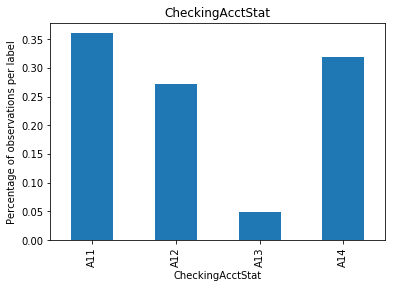

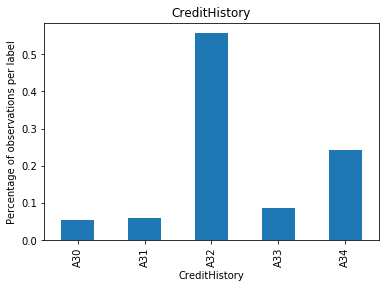

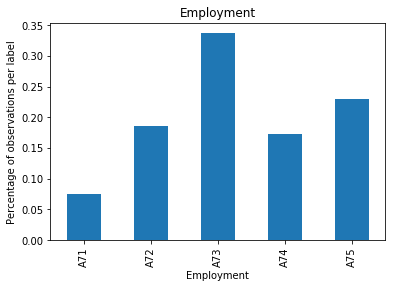

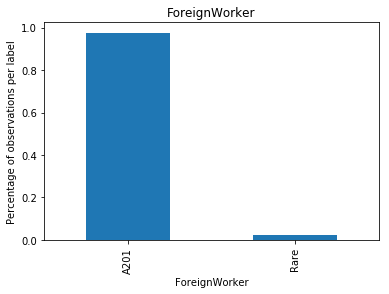

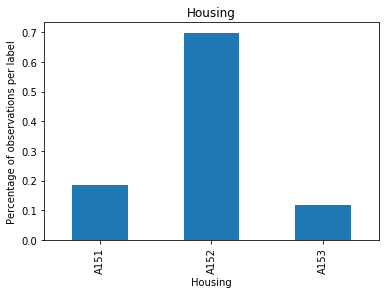

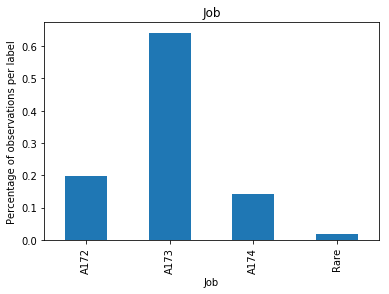

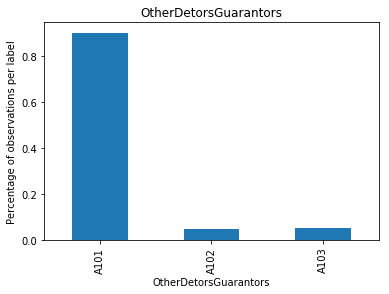

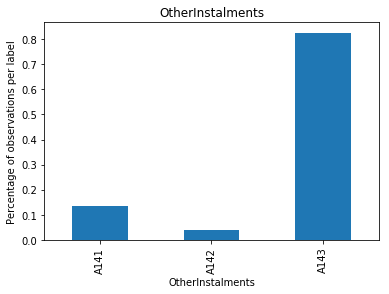

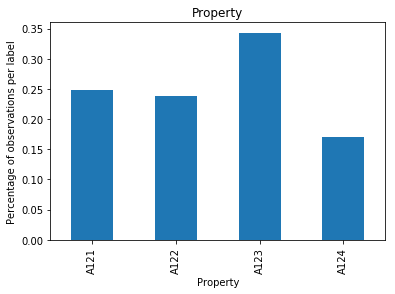

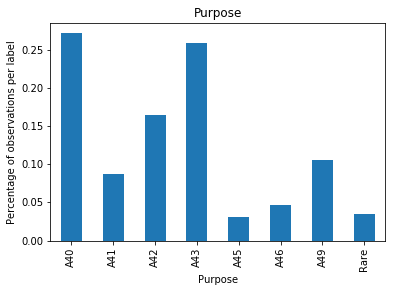

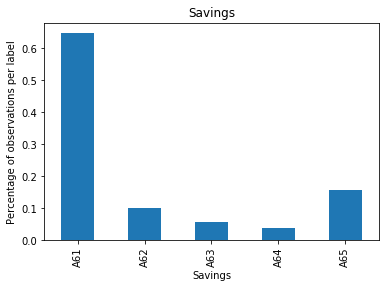

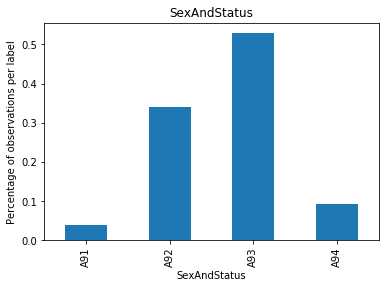

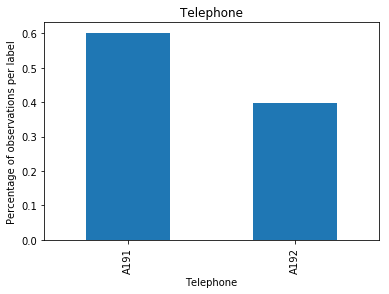

In [58]:
# let's check that it worked
for var in categorical:
    (X_train.groupby(var)[var].count() / np.float(len(X_train))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

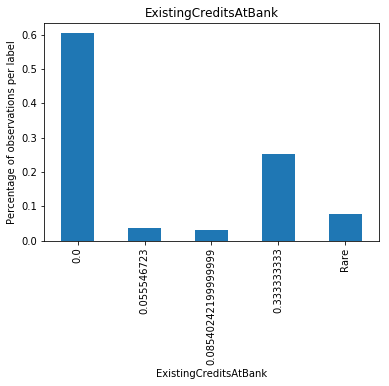

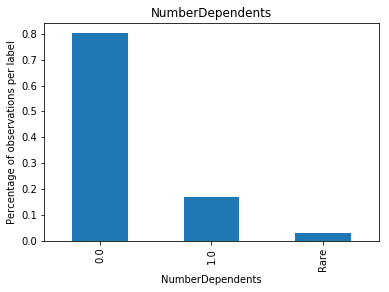

In [59]:
# let's check that it worked
for var in discrete:
    (X_train.groupby(var)[var].count() / np.float(len(X_train))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

YES! It did work well!

### 10. Encoding Categorical Variables

I will proceed with Risk Encoding.

In [60]:
def encode_categorical_variables(var, target):
        # make label to price dictionary
        ordered_labels = X_train.groupby([var])[target].mean().to_dict()
        
        # encode variables
        X_train[var] = X_train[var].map(ordered_labels)
        X_test[var] = X_test[var].map(ordered_labels)

# encode labels in categorical vars
for var in categorical:
    encode_categorical_variables(var, 'CreditStatus')
    
# encode labels in discrete vars
for var in discrete:
    encode_categorical_variables(var, 'CreditStatus')       
        

In [61]:
#let's inspect the dataset
X_train.head()

,Age,CheckingAcctStat,CreditHistory,CreditStatus,Duration,Employment,ExistingCreditsAtBank,ForeignWorker,Housing,InstallmentRatePecnt,Job,NumberDependents,OtherDetorsGuarantors,OtherInstalments,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone,CreditAmount_ordered
424,0.160714,0.645455,0.567929,0,0.029412,0.516129,0.529774,0.557814,0.517730,1.000000,0.546332,0.514706,0.543329,0.531532,1.000000,0.555957,0.444976,0.588123,0.505855,0.541152,0.512195
841,0.051431,0.735395,0.567929,1,0.238102,0.540441,0.529774,0.557814,0.560811,0.333333,0.512500,0.514706,0.543329,0.531532,0.906557,0.445000,0.444976,0.588123,0.583942,0.541152,0.587500
346,0.267857,0.645455,0.567929,0,0.117647,0.646667,0.529774,0.557814,0.560811,0.666667,0.573913,0.533230,0.543329,0.531532,0.000000,0.445000,0.503759,0.588123,0.583942,0.541152,0.587500
418,0.250000,0.272374,0.567929,0,0.029412,0.540441,0.529774,0.557814,0.517730,1.000000,0.546332,0.533230,0.543329,0.531532,0.333333,0.445000,0.503759,0.400000,0.612903,0.541152,0.367089
682,0.134744,0.735395,0.567929,1,0.257328,0.646667,0.529774,0.557814,0.517730,0.561093,0.512500,0.533230,0.543329,0.531532,0.691626,0.555957,0.698630,0.588123,0.505855,0.541152,0.506173


### 11.Feature Scaling

In [62]:
# Check before it is all numerical
X_train.dtypes

Age                      float64
CheckingAcctStat         float64
CreditHistory            float64
CreditStatus               int64
Duration                 float64
Employment               float64
ExistingCreditsAtBank    float64
ForeignWorker            float64
Housing                  float64
InstallmentRatePecnt     float64
Job                      float64
NumberDependents         float64
OtherDetorsGuarantors    float64
OtherInstalments         float64
PresentResidenceTime     float64
Property                 float64
Purpose                  float64
Savings                  float64
SexAndStatus             float64
Telephone                float64
CreditAmount_ordered     float64
dtype: object

In [63]:
# Check before it is all numerical
X_test.dtypes

Age                      float64
CheckingAcctStat         float64
CreditHistory            float64
CreditStatus               int64
Duration                 float64
Employment               float64
ExistingCreditsAtBank    float64
ForeignWorker            float64
Housing                  float64
InstallmentRatePecnt     float64
Job                      float64
NumberDependents         float64
OtherDetorsGuarantors    float64
OtherInstalments         float64
PresentResidenceTime     float64
Property                 float64
Purpose                  float64
Savings                  float64
SexAndStatus             float64
Telephone                float64
CreditAmount_ordered     float64
dtype: object

In [64]:
#Find column names
X_train.columns

Index(['Age', 'CheckingAcctStat', 'CreditHistory', 'CreditStatus', 'Duration',
       'Employment', 'ExistingCreditsAtBank', 'ForeignWorker', 'Housing',
       'InstallmentRatePecnt', 'Job', 'NumberDependents',
       'OtherDetorsGuarantors', 'OtherInstalments', 'PresentResidenceTime',
       'Property', 'Purpose', 'Savings', 'SexAndStatus', 'Telephone',
       'CreditAmount_ordered'],
      dtype='object')

**REMOVE now TARGET from Training_vars (do not include in next cell)**

In [65]:
# let's create a list of the training variables
training_vars = ['Age', 'CheckingAcctStat', 'CreditHistory', 'Duration',
       'Employment', 'ExistingCreditsAtBank', 'ForeignWorker', 'Housing',
       'InstallmentRatePecnt', 'Job', 'NumberDependents',
       'OtherDetorsGuarantors', 'OtherInstalments', 'PresentResidenceTime',
       'Property', 'Purpose', 'Savings', 'SexAndStatus', 'Telephone',
       'CreditAmount_ordered']

print('total number of variables to use for training: ', len(training_vars))

total number of variables to use for training:  20


In [66]:
# let's find the skewness of above variables
for var in training_vars:
    print(var, 'skewness is', df[var].skew() )

Age skewness is 0.9199389285834775
CheckingAcctStat skewness is -0.40010344349500326
CreditHistory skewness is 0.2972930381671155
Duration skewness is 0.8997971880707145
Employment skewness is 0.24357676172471576
ExistingCreditsAtBank skewness is 1.466519308409714
ForeignWorker skewness is -5.786146840774254
Housing skewness is 1.8779002533367668
InstallmentRatePecnt skewness is -0.7882275154092137
Job skewness is -0.37346316500487303
NumberDependents skewness is 4.6000535635460915
OtherDetorsGuarantors skewness is 1.9845228806663033
OtherInstalments skewness is 1.700950808313577
PresentResidenceTime skewness is -0.4352425662787747
Property skewness is 0.5072604725345503
Purpose skewness is 0.02994508437068712
Savings skewness is -1.248643987333662
SexAndStatus skewness is -0.013750884707033329
Telephone skewness is 0.44884989951233023
CreditAmount_ordered skewness is 0.3514365876338875


OK, I shall do :
   - Robust Scaling for variables with an absolute skew above 2
   - MinMax Scaling for variables with an absoulute skew between 1 and 2
   - Standard for the rest

In [67]:
for var in training_vars:
    max_abs_value = 2
    if abs(df[var].skew()) >= max_abs_value:
        print (var)
    

ForeignWorker
NumberDependents


In [68]:
# I Will start with Robust Scaling
scalerR = RobustScaler() # call the object
X_train_scaledR = scalerR.fit_transform(X_train[['ForeignWorker','NumberDependents']]) # fit the scaler to the train set, and then scale it
X_test_scaledR= scalerR.transform(X_test[['ForeignWorker','NumberDependents']]) # scale the test set

In [69]:
for var in training_vars:
    max_abs_value = 2 
    if (1 <= abs(df[var].skew()) <=2):  
        print (var)

ExistingCreditsAtBank
Housing
OtherDetorsGuarantors
OtherInstalments
Savings


In [70]:
#Continue with MinMax Scaling
scalerMM = MinMaxScaler() # create an instance

X_train_scaledMM= scalerMM.fit_transform(X_train[['ExistingCreditsAtBank','Housing','OtherDetorsGuarantors','OtherInstalments', 'Savings']]) #  fit  the scaler to the train set and then transform it
X_test_scaledMM= scalerMM.transform(X_test[['ExistingCreditsAtBank','Housing','OtherDetorsGuarantors','OtherInstalments', 'Savings']]) # transform (scale) the test set



In [71]:
for var in training_vars:
    max_abs_value = 2 
    if ((df[var].skew()) <=1):  
        print (var)

Age
CheckingAcctStat
CreditHistory
Duration
Employment
ForeignWorker
InstallmentRatePecnt
Job
PresentResidenceTime
Property
Purpose
Savings
SexAndStatus
Telephone
CreditAmount_ordered


In [72]:
# Normal Standarization
scalerN = StandardScaler() # create an object
X_train_scaledN = scalerN.fit_transform(X_train[['Age', 'CheckingAcctStat',
                                                'CreditHistory',
                                                'Duration','Employment',
                                                'ForeignWorker', 'InstallmentRatePecnt',
                                                'Job','PresentResidenceTime',
                                                'Property','Purpose',
                                                'Savings', 'SexAndStatus',
                                                'Telephone', 'CreditAmount_ordered']]) # fit the scaler to the train set, and then transform it
X_test_scaledN = scalerN.transform(X_test[['Age', 'CheckingAcctStat',
                                                'CreditHistory',
                                                'Duration','Employment',
                                                'ForeignWorker', 'InstallmentRatePecnt',
                                                'Job','PresentResidenceTime',
                                                'Property','Purpose',
                                                'Savings', 'SexAndStatus',
                                                'Telephone', 'CreditAmount_ordered']]) # transform the test set

### 11. Sanity check (nulls)

In [73]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [74]:
X_train.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_ordered     0
dtype: int64

In [75]:
X_test.isnull().sum()

Age                      0
CheckingAcctStat         0
CreditHistory            0
CreditStatus             0
Duration                 0
Employment               0
ExistingCreditsAtBank    0
ForeignWorker            0
Housing                  0
InstallmentRatePecnt     0
Job                      0
NumberDependents         0
OtherDetorsGuarantors    0
OtherInstalments         0
PresentResidenceTime     0
Property                 0
Purpose                  0
Savings                  0
SexAndStatus             0
Telephone                0
CreditAmount_ordered     0
dtype: int64

In [76]:
y_train.isnull().sum()

CreditStatus    0
dtype: int64

In [77]:
y_test.isnull().sum()

CreditStatus    0
dtype: int64

### 12. Save selected variables for features predictions

In [78]:
X_train_scaledR = pd.DataFrame(X_train_scaledR, columns = ['ForeignWorker','NumberDependents'])
X_train_scaledMM = pd.DataFrame(X_train_scaledMM, columns = ['ExistingCreditsAtBank','Housing','OtherDetorsGuarantors','OtherInstalments', 'Savings'])
X_train_scaledN = pd.DataFrame(X_train_scaledN, columns = ['Age', 'CheckingAcctStat',
                                                'CreditHistory',
                                                'Duration','Employment',
                                                'ForeignWorker', 'InstallmentRatePecnt',
                                                'Job','PresentResidenceTime',
                                                'Property','Purpose',
                                                'Savings', 'SexAndStatus',
                                                'Telephone', 'CreditAmount_ordered'])

######
X_test_scaledR = pd.DataFrame(X_test_scaledR, columns = ['ForeignWorker','NumberDependents'])
X_test_scaledMM = pd.DataFrame(X_test_scaledMM, columns = ['ExistingCreditsAtBank','Housing','OtherDetorsGuarantors','OtherInstalments', 'Savings'])
X_test_scaledN = pd.DataFrame(X_test_scaledN, columns = ['Age', 'CheckingAcctStat',
                                                'CreditHistory',
                                                'Duration','Employment',
                                                'ForeignWorker', 'InstallmentRatePecnt',
                                                'Job','PresentResidenceTime',
                                                'Property','Purpose',
                                                'Savings', 'SexAndStatus',
                                                'Telephone', 'CreditAmount_ordered'])

In [79]:
X_train = pd.concat([X_train_scaledR, X_train_scaledMM, X_train_scaledN], axis=1)
X_test = pd.concat([X_test_scaledR, X_test_scaledMM, X_test_scaledN], axis=1)



In [80]:
X_train.head()

,ForeignWorker,NumberDependents,ExistingCreditsAtBank,Housing,OtherDetorsGuarantors,OtherInstalments,Savings,Age,CheckingAcctStat,CreditHistory,Duration,Employment,ForeignWorker,InstallmentRatePecnt,Job,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone,CreditAmount_ordered
0,0.0,-0.018524,0.236353,0.000000,0.448904,0.0,0.865792,-0.636252,0.497132,0.191354,-1.352681,-0.409002,0.159414,0.903380,0.126865,1.071823,0.154940,-0.805295,0.531338,-0.935114,-0.812708,-0.327484
1,0.0,-0.018524,0.236353,0.276238,0.448904,0.0,0.865792,-1.195709,0.937802,0.191354,-0.141749,-0.052098,0.159414,-0.942668,-1.705831,0.811682,-1.281699,-0.805295,0.531338,0.979650,-0.812708,0.448147
2,0.0,0.000000,0.236353,0.276238,0.448904,0.0,0.865792,-0.087754,0.497132,0.191354,-0.840692,1.507298,0.159414,-0.019644,1.620939,-1.712136,-1.281699,-0.327202,0.531338,0.979650,-0.812708,0.448147
3,0.0,0.000000,0.236353,0.000000,0.448904,0.0,0.000000,-0.179170,-1.330803,0.191354,-1.352681,-0.052098,0.159414,0.903380,0.126865,-0.784149,-1.281699,-0.327202,-1.733584,1.689818,-0.812708,-1.822065
4,0.0,0.000000,0.236353,0.000000,0.448904,0.0,0.865792,-0.769199,0.937802,0.191354,-0.030187,1.507298,0.159414,-0.311985,-1.705831,0.213322,0.154940,1.257710,0.531338,-0.935114,-0.812708,-0.389513


In [81]:
X_train = pd.DataFrame(X_train)
X_train.to_csv('X_train.csv', index=False)

In [82]:
X_test = pd.DataFrame(X_test)
X_test.to_csv('X_test.csv', index=False)

X_test.head()

,ForeignWorker,NumberDependents,ExistingCreditsAtBank,Housing,OtherDetorsGuarantors,OtherInstalments,Savings,Age,CheckingAcctStat,CreditHistory,Duration,Employment,ForeignWorker,InstallmentRatePecnt,Job,PresentResidenceTime,Property,Purpose,Savings,SexAndStatus,Telephone,CreditAmount_ordered
0,0.0,-0.018524,1.000000,0.000000,0.448904,0.000000,0.865792,0.510976,0.937802,2.046422,0.580377,-0.409002,0.159414,0.903380,0.126865,0.642573,-0.200595,1.257710,0.531338,-0.935114,-0.812708,0.448147
1,0.0,0.000000,0.000000,0.000000,0.448904,0.841429,1.000000,1.557739,-1.330803,-1.437935,0.183285,-0.409002,0.159414,0.903380,0.126865,1.071823,-0.200595,-0.805295,0.882429,-0.935114,-0.812708,-0.389513
2,0.0,0.000000,0.236353,0.000000,0.448904,0.000000,0.865792,-0.362003,0.497132,0.191354,-1.011355,-0.052098,0.159414,0.903380,-1.705831,-0.784149,0.154940,-0.327202,0.531338,1.689818,-0.812708,-1.822065
3,0.0,0.000000,0.236353,0.000000,0.448904,0.000000,0.019584,-0.819084,-1.330803,0.191354,0.183285,-0.409002,0.159414,-0.019644,1.620939,-0.784149,0.154940,-0.805295,-1.682352,1.689818,1.230455,-0.262354
4,0.0,0.000000,0.236353,0.276238,0.000000,0.000000,1.000000,-1.276166,0.497132,0.191354,1.975244,-0.052098,0.159414,0.903380,0.126865,1.071823,-0.200595,-0.805295,0.882429,-0.935114,-0.812708,0.448147


In [83]:
y_train = pd.DataFrame(y_train)
y_train.to_csv('y_train.csv', index=False)

y_train.head()

,CreditStatus
424,0
841,1
346,0
418,0
682,1


In [84]:
y_test = pd.DataFrame(y_test)
y_test.to_csv('y_test.csv', index=False)